In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

import jax
from jax import numpy as jnp
from jax import random

import optax

from src.QDDPM_jax import QDDPM, HaarSampleGeneration
from src.distance_jax import naturalDistance, WassDistance, sinkhornDistance

rc('text', usetex=True)
rc('axes', linewidth=3)

2023-11-08 13:48:33.649949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
/home/francishsu/miniconda3/lib/python3.11/site-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
2023-11-08 13:48:36.034739: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/home/francishsu/minicon

In [2]:
# check device
print(jax.lib.xla_bridge.get_backend().platform)

gpu


In [3]:
def Training_t(model, t, inputs_T, params_tot, epochs, dis_measure='wd'):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    epochs: number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    Ndata = inputs_T.shape[0]

    input_tplus1 = model.prepareInput_t(
        inputs_T, params_tot, t, Ndata)  # prepare input
    states_diff = model.states_diff
    loss_hist = []  # record of training history

    # initialize parameters
    key = random.PRNGKey(np.random.randint(low=0, high=10000))
    param_shape = 2 * model.n_tot * model.L
    params_t = random.normal(key, shape=(param_shape, ))

    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate=5e-4)
    opt_state = optimizer.init(params_t)

    if dis_measure == 'nat':
        def loss_func(params_t, input_tplus1, true_data):
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = naturalDistance(output_t, true_data)

            return loss

    elif dis_measure == 'wd':
        def loss_func(params_t, input_tplus1, true_data):
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = sinkhornDistance(output_t, true_data, reg=0.01)

            return loss

    loss_func_vg = jax.jit(jax.value_and_grad(loss_func))
    # @partial(jax.jit, static_argnums=(2, ))

    def update(params_t, input_tplus1, true_data, opt_state):
        loss_value, grads = loss_func_vg(params_t, input_tplus1, true_data)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_t)
        new_params_t = optax.apply_updates(params_t, updates)

        return new_params_t, new_opt_state, loss_value

    t0 = time.time()
    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(
            states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        params_t, opt_state, loss_value = update(
            params_t, input_tplus1, true_data, opt_state)

        if step % 100 == 0:
            print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(
                step, loss_value, time.time() - t0))

        loss_hist.append(loss_value)  # record the current loss

    return params_t, loss_hist

In [4]:
n, na = 6, 4
T = 20
L = 12

Ndata = 10000
epochs = 1201

inputs_T = HaarSampleGeneration(Ndata, 2 ** n, seed=42)
states_diff = jnp.load('data/cluster/cluster0Diff_n6T%d_N10000.npy' % T)

In [5]:
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)
params_tot = jnp.zeros((T, 2 * (n + na) * L))

In [6]:
params, loss = Training_t(model, T - 1, inputs_T, params_tot, epochs, 'nat')

Step 0, loss: 0.0016625, time elapsed: 12.8955 seconds
Step 100, loss: 0.0010737, time elapsed: 46.4125 seconds
Step 200, loss: 0.0008225, time elapsed: 79.4589 seconds
Step 300, loss: 0.0006824, time elapsed: 112.5548 seconds
Step 400, loss: 0.0005838, time elapsed: 145.6682 seconds
Step 500, loss: 0.0005132, time elapsed: 178.8124 seconds
Step 600, loss: 0.0004685, time elapsed: 211.9511 seconds
Step 700, loss: 0.0004368, time elapsed: 245.1273 seconds
Step 800, loss: 0.0004139, time elapsed: 278.2546 seconds
Step 900, loss: 0.0003952, time elapsed: 311.4489 seconds
Step 1000, loss: 0.0003745, time elapsed: 344.6244 seconds
Step 1100, loss: 0.0003569, time elapsed: 377.8495 seconds
Step 1200, loss: 0.0003394, time elapsed: 410.9998 seconds


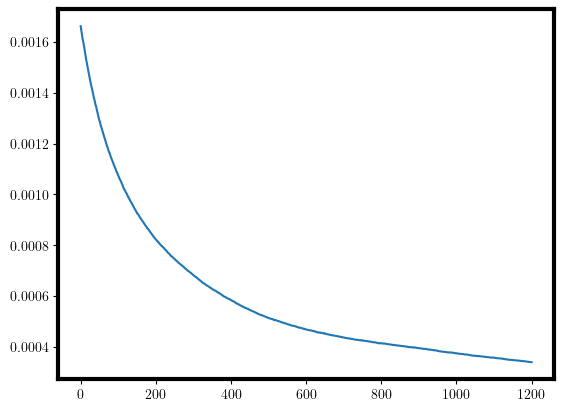

In [27]:
plt.plot(jnp.hstack(loss))